<a href="https://colab.research.google.com/github/AsmaaYassinDev/Context-Aware-Fraud-Detection/blob/main/train_ablation_unweighted_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- STEP 1: LOADING DATA ---
⚠️ Data not found. Starting Download...
Please upload 'kaggle.json' file now:


Saving kaggle.json to kaggle.json
  0% 0.00/118M [00:00<?, ?B/s]
100% 118M/118M [00:00<00:00, 2.67GB/s]
Archive:  ieee-fraud-detection.zip
  inflating: sample_submission.csv   
  inflating: test_identity.csv       
  inflating: test_transaction.csv    
  inflating: train_identity.csv      
  inflating: train_transaction.csv   
unzip:  cannot find or open train_transaction.csv.zip, train_transaction.csv.zip.zip or train_transaction.csv.zip.ZIP.
unzip:  cannot find or open train_identity.csv.zip, train_identity.csv.zip.zip or train_identity.csv.zip.ZIP.
✅ Download & Unzip Complete.
Loading CSVs into Memory...


/tmp/ipython-input-1161749540.py:54: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-1161749540.py:54: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-1161749540.py:54: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-1161749540.py:54: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-1161749540.py:54: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-116174


--- STEP 2: ENGINEERING FEATURES (LEAKAGE-FREE) ---


/tmp/ipython-input-1161749540.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['hour'] = (df['TransactionDT'] // 3600) % 24
/tmp/ipython-input-1161749540.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['UID'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str) + '_' + df['P_emaildomain'].astype(str)


Generating Behavioral Features (Expanding Windows)...


/tmp/ipython-input-1161749540.py:100: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['User_Trans_Count'] = df.groupby('UID').cumcount() + 1
/tmp/ipython-input-1161749540.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['User_Mean_Amt'] = df.groupby('UID')['TransactionAmt'].transform(lambda x: x.expanding().mean())
/tmp/ipython-input-1161749540.py:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

✅ Features Created (Leakage-Free).

--- STEP 3: TRAINING (NO WEIGHTS - STRICT 80/20) ---
Training Set (First 80%): 472,432 rows
Testing Set  (Last 20%):  118,108 rows
Training Standard XGBoost...
✅ Training Complete.

--- STEP 4: ABLATION RESULTS ---
ROC-AUC Score (No Weights): 0.9169

--- Classification Report (Default Threshold) ---
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99    114044
       Fraud       0.84      0.36      0.51      4064

    accuracy                           0.98    118108
   macro avg       0.91      0.68      0.75    118108
weighted avg       0.97      0.98      0.97    118108



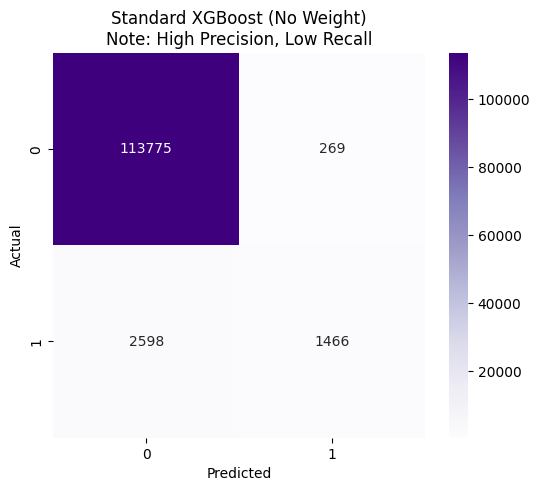

In [1]:
# ==========================================
# 5. ABLATION STUDY: NO COST-SENSITIVE LEARNING
# Hypothesis: Without 'scale_pos_weight', the model will have Low Recall.
# CONSTRAINT: Strict 80/20 Split & No Data Leakage
# ==========================================

import os
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from google.colab import files
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# STEP 1: ROBUST DATA LOADING
# ---------------------------------------------------------
print("--- STEP 1: LOADING DATA ---")

def force_download():
    if os.path.exists('train_transaction.csv'):
        print("✅ Data found. Loading...")
        return

    print("⚠️ Data not found. Starting Download...")
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        print("Please upload 'kaggle.json' file now:")
        uploaded = files.upload()
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

    !kaggle competitions download -c ieee-fraud-detection
    !unzip -o ieee-fraud-detection.zip
    !unzip -o train_transaction.csv.zip
    !unzip -o train_identity.csv.zip
    print("✅ Download & Unzip Complete.")

force_download()

def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: df[col] = df[col].astype(np.float32)
    return df

print("Loading CSVs into Memory...")
train_trans = reduce_mem_usage(pd.read_csv('train_transaction.csv'))
train_id = reduce_mem_usage(pd.read_csv('train_identity.csv'))
df = pd.merge(train_trans, train_id, on='TransactionID', how='left')
del train_trans, train_id
gc.collect()

# ---------------------------------------------------------
# STEP 2: FEATURE ENGINEERING (LEAKAGE-FREE)
# ---------------------------------------------------------
print("\n--- STEP 2: ENGINEERING FEATURES (LEAKAGE-FREE) ---")

# 1. Sort by Time (Crucial for Time-Series logic)
df = df.sort_values('TransactionDT').reset_index(drop=True)

# A. Filtering
df = df.drop(columns=df.columns[df.isnull().mean() > 0.95])
df = df.drop(columns=df.nunique()[df.nunique() == 1].index)

# B. Imputation
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna('Unknown')
for col in df.select_dtypes(exclude=['object']).columns:
    df[col] = df[col].fillna(-1)

# C. Timezone Fix
if 'id_14' in df.columns:
    df['id_14'] = df['id_14'].astype(str)

# D. Encoding
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# E. Context-Aware Features
df['hour'] = (df['TransactionDT'] // 3600) % 24
df['UID'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str) + '_' + df['P_emaildomain'].astype(str)

# F. Behavioral Profiling (LEAKAGE-FREE UPDATE)
# We use expanding() windows so we calculate stats based ONLY on past history.
print("Generating Behavioral Features (Expanding Windows)...")

# Velocity: Cumulative count up to current row
df['User_Trans_Count'] = df.groupby('UID').cumcount() + 1

# Spending Deviation: Expanding Mean
df['User_Mean_Amt'] = df.groupby('UID')['TransactionAmt'].transform(lambda x: x.expanding().mean())
df['Amt_Deviation'] = df['TransactionAmt'] / (df['User_Mean_Amt'] + 1e-5)

# Time Behavior: Expanding Mean per Hour
df['User_Hour_Mean'] = df.groupby(['UID', 'hour'])['TransactionAmt'].transform(lambda x: x.expanding().mean())
df['Time_Behavior_Deviation'] = df['TransactionAmt'] / (df['User_Hour_Mean'] + 1e-5)

print("✅ Features Created (Leakage-Free).")

# ---------------------------------------------------------
# STEP 3: TRAINING STANDARD XGBOOST (NO WEIGHTS)
# ---------------------------------------------------------
print("\n--- STEP 3: TRAINING (NO WEIGHTS - STRICT 80/20) ---")

# 1. Define Split Point (80% Train, 20% Test)
split_idx = int(len(df) * 0.8)

# 2. Create Train (Historical) and Test (Future)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"Training Set (First 80%): {len(train_df):,} rows")
print(f"Testing Set  (Last 20%):  {len(test_df):,} rows")

exclude = ['isFraud', 'TransactionID', 'TransactionDT', 'UID', 'User_Mean_Amt', 'User_Hour_Mean']
features = [c for c in df.columns if c not in exclude]

X_train = train_df[features]
y_train = train_df['isFraud']
X_test = test_df[features]
y_test = test_df['isFraud']

# NOTICE: No 'scale_pos_weight' parameter here! (Default = 1)
print("Training Standard XGBoost...")
model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.7,
    # scale_pos_weight=1,  <-- THIS IS THE DIFFERENCE (No Cost-Sensitivity)
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("✅ Training Complete.")

# ---------------------------------------------------------
# STEP 4: RESULTS & COMPARISON
# ---------------------------------------------------------
print("\n--- STEP 4: ABLATION RESULTS ---")

y_probs = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC Score (No Weights): {auc:.4f}")

# Use Standard Threshold (0.5) to show the bias towards majority class
y_pred_default = (y_probs >= 0.5).astype(int)

print("\n--- Classification Report (Default Threshold) ---")
print(classification_report(y_test, y_pred_default, target_names=['Normal', 'Fraud']))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_default)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title(f'Standard XGBoost (No Weight)\nNote: High Precision, Low Recall')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [2]:
# ==========================================
# THESIS ANALYSIS: FEATURE RANKING (NO WEIGHTS)
# Purpose: To see if the model ignores behavioral features when not forced to find fraud.
# ==========================================
import pandas as pd

# 1. Extract Feature Importance
importance_dict = model.get_booster().get_score(importance_type='gain')

# Convert to DataFrame
imp_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
}).sort_values(by='Gain', ascending=False).reset_index(drop=True)

# Add Rank Column
imp_df['Rank'] = imp_df.index + 1

# 2. Define Your Engineered Features
my_features = [
    'User_Trans_Count',         # Velocity
    'Amt_Deviation',            # Contextual Spending
    'Time_Behavior_Deviation',  # Contextual Timing
    'User_Mean_Amt',
    'User_Hour_Mean',
    'hour',
    'day'
]

print(f"Total Features in Model (No Weights): {len(imp_df)}")
print("\n--- 📊 RANKING OF YOUR FEATURES (STANDARD XGBOOST) 📊 ---")
print(f"{'Feature Name':<25} | {'Rank':<5} | {'Gain':<10} | {'Status'}")
print("-" * 60)

for feat in my_features:
    if feat in imp_df['Feature'].values:
        row = imp_df[imp_df['Feature'] == feat].iloc[0]
        rank = int(row['Rank'])
        gain = row['Gain']

        # Interpretation
        if rank <= 20: status = "🌟 STAR"
        elif rank <= 100: status = "✅ STRONG"
        else: status = "🔸 WEAK"

        print(f"{feat:<25} | #{rank:<4} | {gain:<10.2f} | {status}")
    else:
        print(f"{feat:<25} | ----  | 0.00       | ❌ IGNORED")

# 3. Compare with Top 1
top_feat = imp_df.iloc[0]
print("\n--- 🏆 DOMINANT FEATURE ---")
print(f"Top Feature: {top_feat['Feature']} (Gain: {top_feat['Gain']:.2f})")

Total Features in Model (No Weights): 412

--- 📊 RANKING OF YOUR FEATURES (STANDARD XGBOOST) 📊 ---
Feature Name              | Rank  | Gain       | Status
------------------------------------------------------------
User_Trans_Count          | #221  | 7.93       | 🔸 WEAK
Amt_Deviation             | #314  | 5.75       | 🔸 WEAK
Time_Behavior_Deviation   | #337  | 5.39       | 🔸 WEAK
User_Mean_Amt             | ----  | 0.00       | ❌ IGNORED
User_Hour_Mean            | ----  | 0.00       | ❌ IGNORED
hour                      | #313  | 5.77       | 🔸 WEAK
day                       | ----  | 0.00       | ❌ IGNORED

--- 🏆 DOMINANT FEATURE ---
Top Feature: V201 (Gain: 849.05)
